# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 54

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

(4096, 12, 12, 2)
(3000, 12, 12, 2)
(21, 12, 12, 2)
(3000, 12, 12, 2)


In [7]:
print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(4096,)
(21,)
(3000,)


In [8]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [9]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(78, 2, 3000)
(78, 2, 4096)
(78, 2, 21)
(78, 2, 3000)


In [10]:
og_freqs = data_dict['og_freqs']
gt_freqs = data_dict['gt_freqs']

In [11]:
print(og_freqs.shape)
print(gt_freqs.shape)

(3000,)
(4096,)


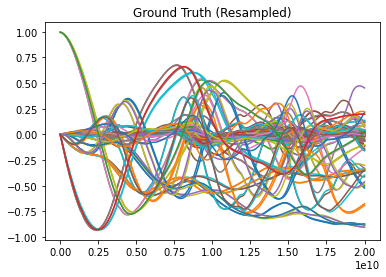

In [12]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth (Resampled)")
plt.show()

In [13]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print(gt_mag.shape)

torch.Size([78, 4096])


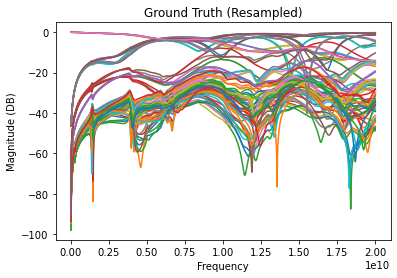

In [14]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth (Resampled)")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

### Check the data for some smoothness and regularity conditions

In [15]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(78, 2, 4095)


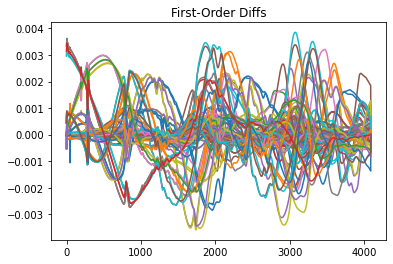

In [16]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("First-Order Diffs")
plt.show()

(78, 2, 4094)


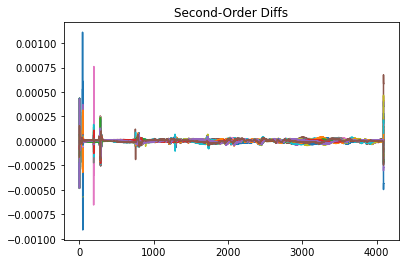

In [17]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Grab some measurements

In [18]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = int(data_dict['y_freqs'].shape[0] * (gt_freqs.shape[0] / og_freqs.shape[0]))

In [19]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [20]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

4096
28
29
4067


## Make the final data

In [21]:
x = torch.from_numpy(gt_data).type(torch.float32)
x = x.view(-1, LENGTH).unsqueeze(0)

In [22]:
print(x.shape)

torch.Size([1, 156, 4096])


In [23]:
y = torch.clone(x)[:, :, kept_inds]

In [24]:
print(y.shape)

torch.Size([1, 156, 29])


## Make sure that we can transform it back to the OG shape/size

In [25]:
x_temp = utils.sparams_to_matrix(x)

In [26]:
print(x_temp.shape)
print(x_temp.dtype)
print(x_temp.device)

torch.Size([4096, 12, 12, 2])
torch.float32
cpu


In [27]:
diff = x_temp - torch.from_numpy(data_dict['gt_matrix']).type(torch.float32)

print(torch.mean(diff).item())

-0.023315580561757088


## Visualize the data and observations

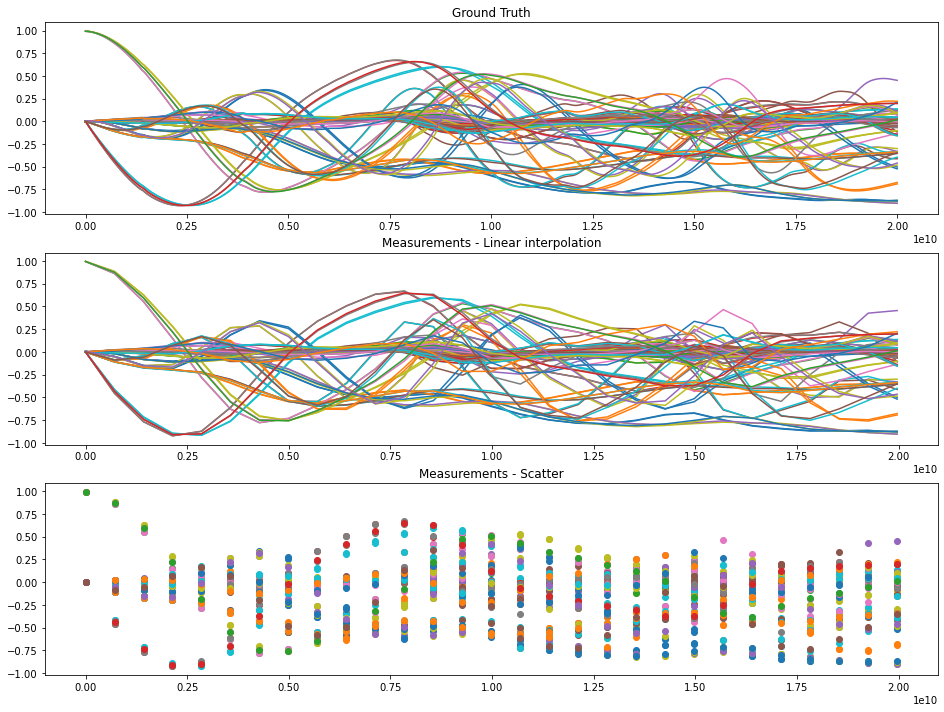

In [28]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].scatter(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[2].set_title("Measurements - Scatter")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [29]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print(x_mag.shape)
print(y_mag.shape)

torch.Size([78, 4096])
torch.Size([78, 29])


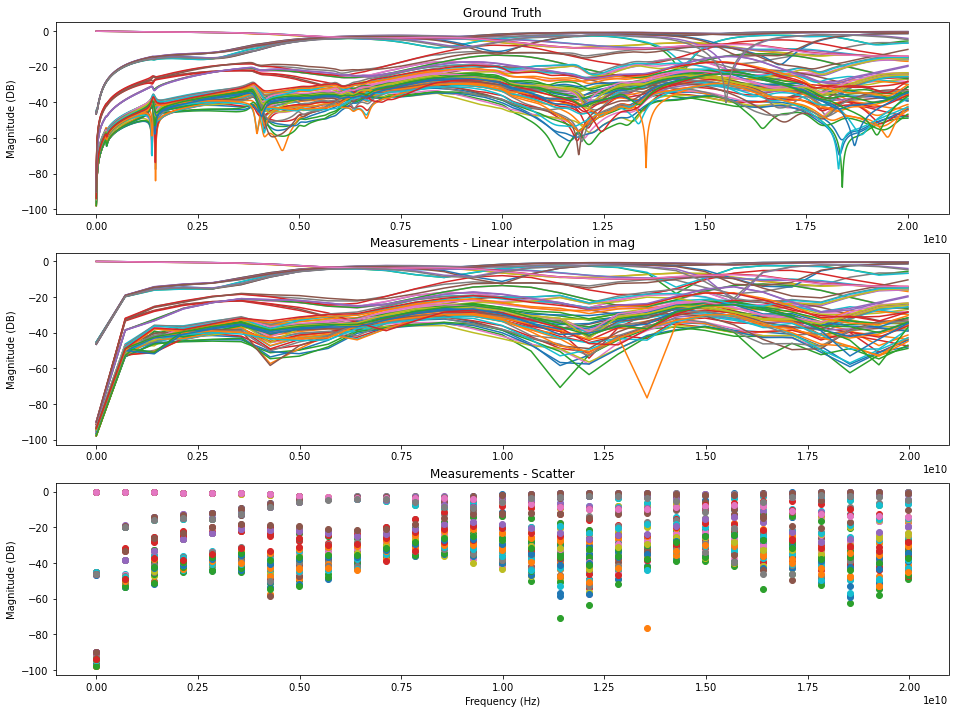

In [30]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[1].set_title("Measurements - Linear interpolation in mag")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[2].set_title("Measurements - Scatter")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

# Set up the network

In [31]:
LR = 1e-4 # learning rate
NUM_ITER = 25000 # number iterations

NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 1
NUM_LAYERS = max(NUM_LAYERS, 5)

BASE_NGF = 2 ** int(np.ceil(np.log2(NZ)))
NGF = [int(BASE_NGF * 2**(i/2)) for i in range(NUM_LAYERS)]

BS = y.shape[0]
NC = y.shape[1]

In [32]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  156
NUM_LAYERS:  11
BASE NGF:  256
NGF:  [256, 362, 512, 724, 1024, 1448, 2048, 2896, 4096, 5792, 8192]
BS:  1
NC:  156


In [33]:
from models import RES_UNET

KERNEL_SIZE = 1

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, num_layers=NUM_LAYERS)
net = net.to(device)

In [34]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 156, 4096])


/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [35]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  753841720


# Make the linear interpolation and use it as the input to the network

In [36]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [37]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

(1, 156, 4096)


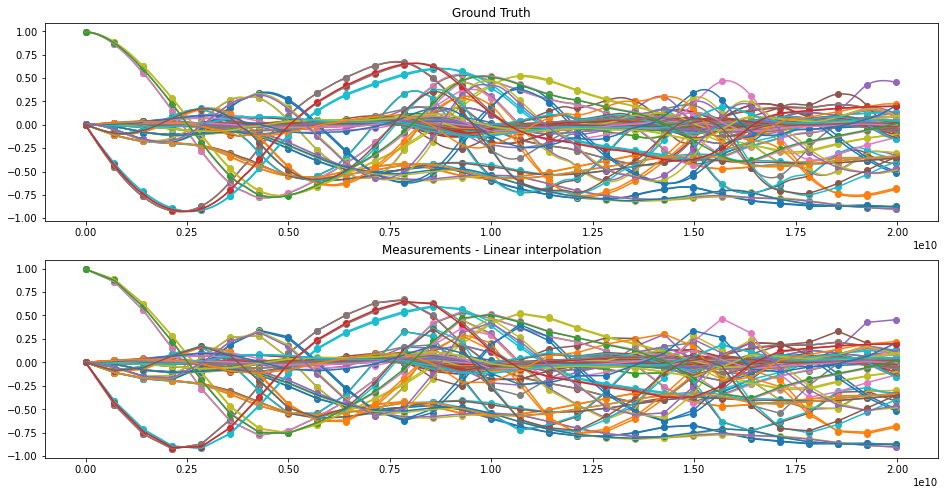

In [38]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [39]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print(y_interp_mag.shape)

torch.Size([78, 4096])


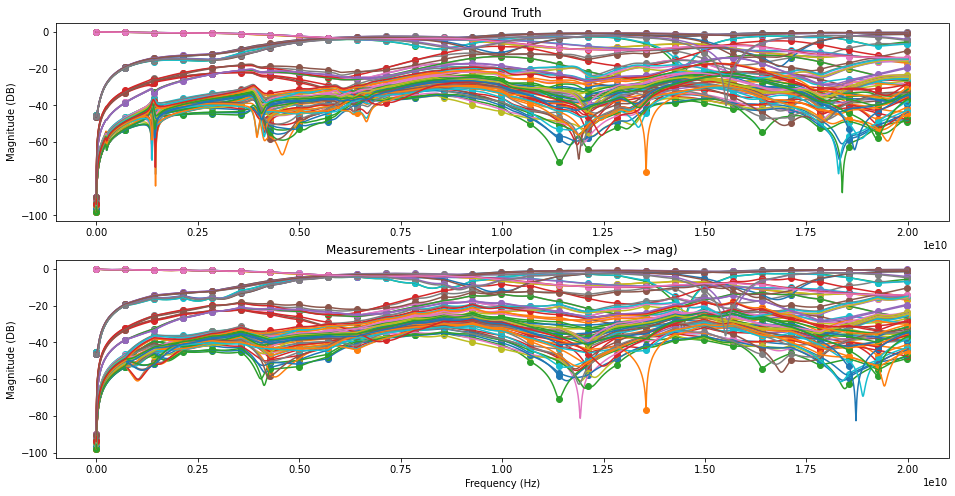

In [40]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [41]:
net.set_z(y_interp)

y_interp = torch.from_numpy(y_interp).type(torch.float32)
y_interp = y_interp.to(device)

# Run

In [42]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

regularizer = utils.Smoothing_Loss(per_param=True, reduction="mean")
regularizer = regularizer.to(device)

REG_HYPERPARAM = 10000

In [43]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
train_errors = []
train_regs = []

test_mses = []
test_maes = []

# outputs = []

x = x.to(device)
y = y.to(device)

In [44]:
tic = time.time()
for i in range(NUM_ITER):
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    
    train_error = criterion(out, y) 
    train_reg = REG_HYPERPARAM * regularizer(out)
    train_loss = train_error + train_reg
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
#         outputs.append(out.detach().clone().cpu())
        
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.33820390701293945

ITER  999
TIME:  170.8274440765381

ITER  1999
TIME:  341.47232580184937

ITER  2999
TIME:  512.0885224342346

ITER  3999
TIME:  682.7709295749664

ITER  4999
TIME:  853.4453704357147

ITER  5999
TIME:  1024.1077888011932

ITER  6999
TIME:  1194.7720749378204

ITER  7999
TIME:  1365.4178059101105

ITER  8999
TIME:  1536.0879006385803



KeyboardInterrupt: 

# Plot the last and best outputs and the metrics

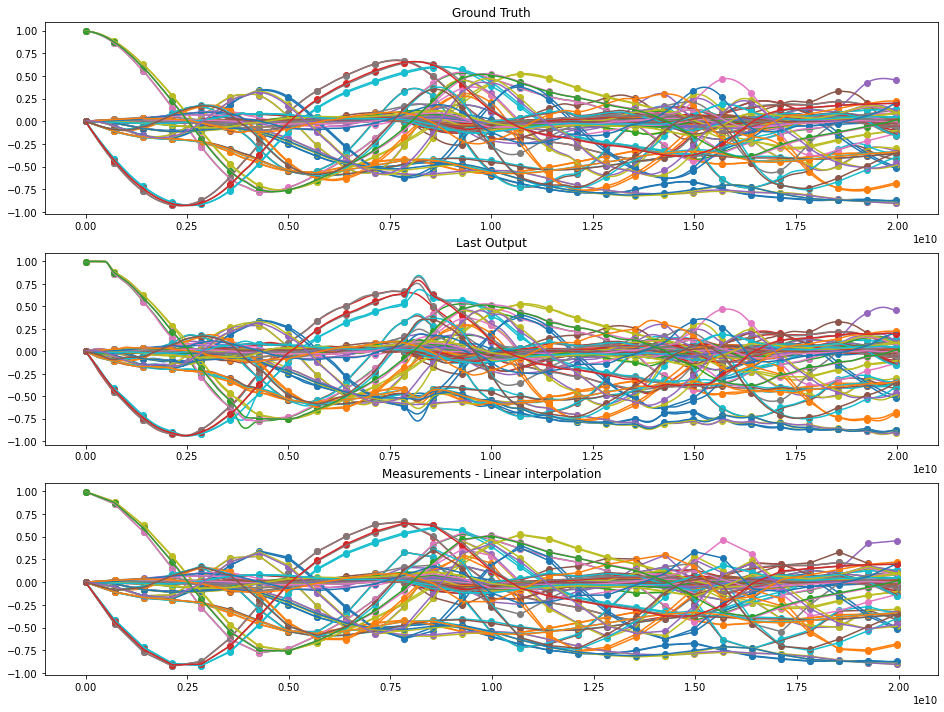

In [45]:
out = out.detach().clone().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
        axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [46]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

torch.Size([78, 4096])


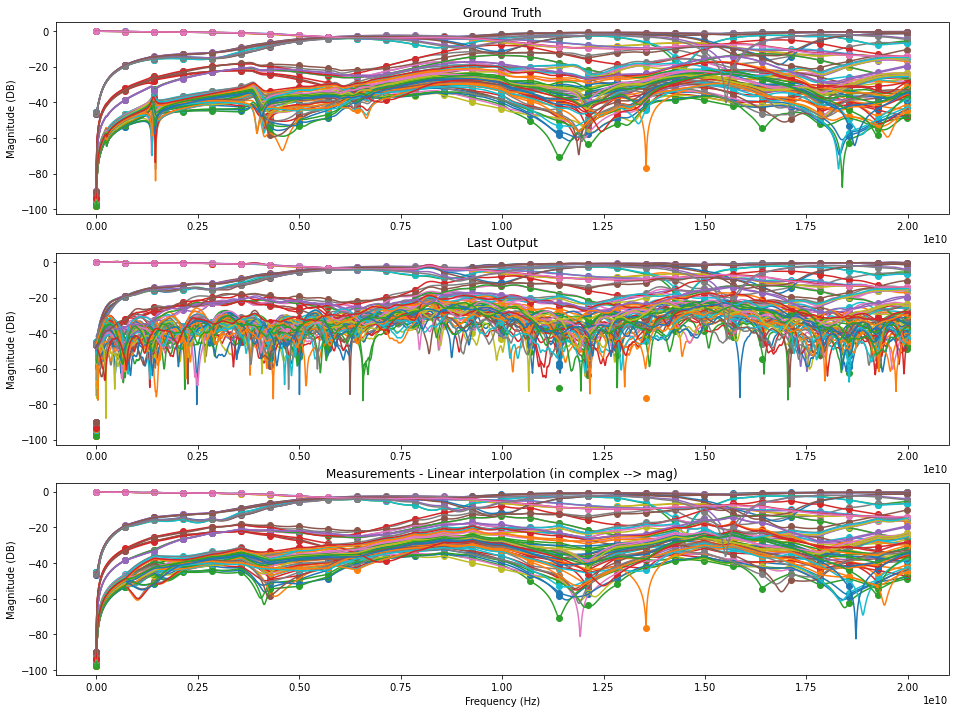

In [47]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

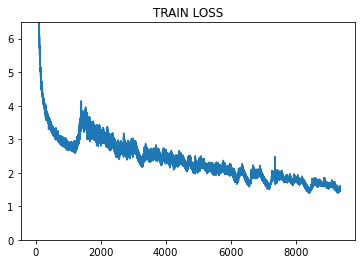

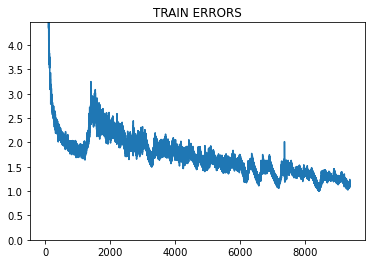

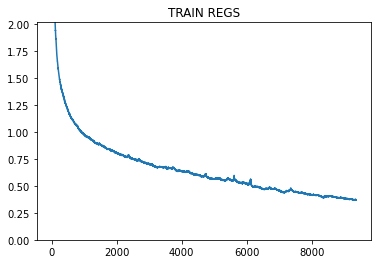

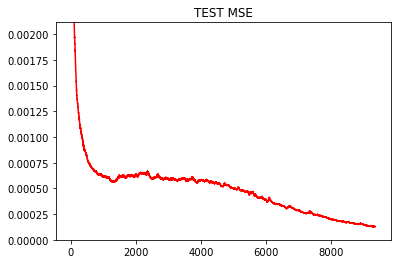

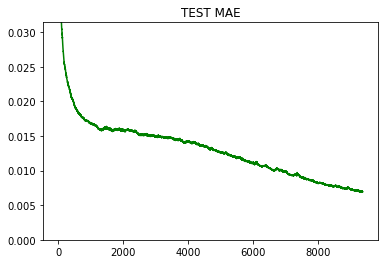

In [48]:
max_idx = 100 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(train_regs)
plt.title("TRAIN REGS")
plt.ylim(0., train_regs[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()